### ヒートマップ作成コード

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import os

In [27]:
# --- ゾーン分類のための境界線（単位はデータによるが、ここではインチを想定） ---
Y_LOW_BOUNDARY = 50
Y_HIGH_BOUNDARY = 120
X_INNER_BOUNDARY = -30
X_OUTER_BOUNDARY = 30

def classify_height(y):
    """Y座標（高さ）を Low, Middle, High に分類する"""
    if y < Y_LOW_BOUNDARY:
        return 'Low'
    elif y < Y_HIGH_BOUNDARY:
        return 'Middle'
    else:
        return 'High'

def classify_width(x):
    """X座標（左右）を Inner, Middle, Outer に分類する"""
    if x < X_INNER_BOUNDARY:
        return 'Inner'
    elif x < X_OUTER_BOUNDARY:
        return 'Middle'
    else:
        return 'Outer'

In [28]:
def create_batting_heatmap(input_csv_path, pitcher_id_col='pitcher_id', target_pitcher_id=None):
    """
    指定されたCSVファイルを読み込み、ゾーン別打率を計算し、ヒートマップを生成する。
    Args:
        input_csv_path (str): CSVファイルのパス。
        pitcher_id_col (str): 投手IDが格納されている列名。
        target_pitcher_id (int/str): 絞り込みたい特定の投手ID。Noneの場合、全投手の合計を計算。
    """
    
    # --- A. データ読み込みと準備 ---
    REQUIRED_COLS = ['pitch_location_x', 'pitch_location_y', 'is_h', 'is_ab', 'is_bb', 'is_hbp', pitcher_id_col] # 投手ID列を追加
    df = None
    
    try:
        # CSVファイルを読み込む（エンコーディングはcp932を試す）
        df = pd.read_csv(input_csv_path, encoding='cp932')
        print(f"✅ ファイル '{input_csv_path}' を正常に読み込みました。")
        # ‼️ 追加: 読み込んだデータに is_pa がない場合、計算して追加 ‼️
        if 'is_pa' not in df.columns:
             df['is_pa'] = df['is_ab'] + df['is_bb'] + df['is_hbp']
        if not all(col in df.columns for col in REQUIRED_COLS):
            print(f"❌ エラー: CSVファイルに必要な列 ({REQUIRED_COLS}) が揃っていません。ダミーデータを使用します。")
            raise Exception("Missing required columns for calculation.")
             
    except Exception as e:
        # ... (ダミーデータ作成ロジック: 投手ID列も追加) ...
        print(f"🛑 エラーが発生しました: {e}。シミュレーション用のダミーデータで処理を続行します。")
        data_size = 500
        df = pd.DataFrame({
            # ... (他の列のダミーデータ) ...
            'pitch_location_x': np.random.uniform(-100, 100, data_size),
            'pitch_location_y': np.random.uniform(0, 250, data_size),
            'is_h': np.random.choice([0, 1], size=data_size, p=[0.8, 0.2]), 
            'is_ab': np.random.choice([0, 1], size=data_size, p=[0.2, 0.8]), 
            'is_bb': np.random.choice([0, 1], size=data_size, p=[0.9, 0.1]),
            'is_hbp': np.random.choice([0, 1], size=data_size, p=[0.98, 0.02]),
            pitcher_id_col: np.random.choice([101, 102, 103], size=data_size) # ダミー投手ID
        })
        # ‼️ 修正点: ダミーデータ作成直後に is_pa を計算して追加 ‼️
        df['is_pa'] = df['is_ab'] + df['is_bb'] + df['is_hbp']
        df.loc[df['is_ab'] == 0, 'is_h'] = 0
        df = df[df['is_pa'] > 0]
        # ... (後略) ...

    # --- B. 投手フィルタリングの追加（新規ロジック） ---
    if target_pitcher_id is not None:
        try:
            # 整数型か文字列型かに関わらずフィルタリング
            df = df[df[pitcher_id_col].astype(str) == str(target_pitcher_id)]
            if df.empty:
                print(f"⚠️ 警告: 投手ID '{target_pitcher_id}' のデータが見つかりませんでした。処理を終了します。")
                return
            print(f"✅ 投手ID '{target_pitcher_id}' のデータに絞り込みました。")
        except KeyError:
            print(f"❌ エラー: フィルタリングに指定された列名 '{pitcher_id_col}' がデータフレームに存在しません。")
            return


    # --- C. ゾーン分類を実行 ---
    # ... (classify_height, classify_width の適用) ...
    df['Height_Zone'] = df['pitch_location_y'].apply(classify_height)
    df['Width_Zone'] = df['pitch_location_x'].apply(classify_width)
    df['Pitch_Zone'] = df['Width_Zone'] + '-' + df['Height_Zone'] 


    # --- D. ゾーン別打率の計算とヒートマップ行列の作成 ---
    zone_summary_pivot = df.groupby(['Height_Zone', 'Width_Zone']).agg(
        hits=('is_h', 'sum'),
        at_bats=('is_ab', 'sum'),
        total_pitches=('is_h', 'size')
    )
    # ... (BA計算、ba_matrix作成ロジック) ...
    zone_summary_pivot['BA'] = np.where(zone_summary_pivot['at_bats'] > 0, 
                                        zone_summary_pivot['hits'] / zone_summary_pivot['at_bats'], 0)
    ba_matrix = zone_summary_pivot['BA'].unstack(fill_value=0)
    ba_matrix = ba_matrix.reindex(index=['High', 'Middle', 'Low'], columns=['Inner', 'Middle', 'Outer'])
    # ... (総合成績計算ロジック) ...
    total_ab = df['is_ab'].sum()
    total_h = df['is_h'].sum()
    total_bb = df['is_bb'].sum()
    total_hbp = df['is_hbp'].sum()
    total_pa = df['is_pa'].sum()
    total_slg = total_h / total_ab if total_ab > 0 else 0 
    ba = total_h / total_ab if total_ab > 0 else 0
    obp = (total_h + total_bb + total_hbp) / total_pa if total_pa > 0 else 0
    ops = obp + total_slg
    
    print("✅ 成績計算が完了しました。")

    # --- E. ヒートマップの描画 ---
    # タイトルに投手名を追加して変更
    title_suffix = f" (Pitcher ID: {target_pitcher_id})" if target_pitcher_id is not None else " (Overall)"
    
    # ... (描画コードの本体は変更なし) ...
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(3, 3, figure=fig, width_ratios=[3, 0.1, 1], hspace=0.3, wspace=0.3) 

    ax_heatmap = fig.add_subplot(gs[:, 0])
    sns.heatmap(
        ba_matrix, annot=True, fmt=".3f", linewidths=.5, linecolor='white',
        cmap='coolwarm', cbar_ax=fig.add_subplot(gs[:, 1]),
        yticklabels=['High', 'Middle', 'Low'], xticklabels=['Inner', 'Middle', 'Outer'],
        vmin=ba_matrix.values.min(), vmax=ba_matrix.values.max(), ax=ax_heatmap
    )
    # ‼️ タイトルに投手情報を追加 ‼️
    ax_heatmap.set_title('Course-Specific Batting Average (BA) Heatmap' + title_suffix, fontsize=16)

    # ... (サイドパネルの描画コードもそのまま使用) ...
    ax_card = fig.add_subplot(gs[0, 2])
    ax_card.set_title('Overall Hitting Card', fontsize=14, pad=10)
    ax_card.axis('off')
    ax_card.text(0.1, 0.8, 'BA (打率):', fontsize=12, weight='bold'); ax_card.text(0.6, 0.8, f'{ba:.3f}', fontsize=14, color='red')
    ax_card.text(0.1, 0.5, 'OBP (出塁率):', fontsize=12, weight='bold'); ax_card.text(0.6, 0.5, f'{obp:.3f}', fontsize=14, color='darkgreen')
    ax_card.text(0.1, 0.2, 'OPS (貢献度):', fontsize=12, weight='bold'); ax_card.text(0.6, 0.2, f'{ops:.3f}', fontsize=14, color='blue')
    
    ax_bar = fig.add_subplot(gs[1:, 2])
    zone_names_for_bar = zone_summary_pivot.index.get_level_values('Width_Zone') + \
                         '-' + zone_summary_pivot.index.get_level_values('Height_Zone')
                         
    sns.barplot(
        x=zone_names_for_bar, 
        y=zone_summary_pivot['total_pitches'], 
        ax=ax_bar, 
        palette='viridis'
    )
    ax_bar.set_title('Total Pitches per Zone', fontsize=12)
    ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax_bar.set_xlabel('Pitch Zone'); ax_bar.set_ylabel('Total Pitches')

    plt.tight_layout()
    plt.show()

🛑 エラーが発生しました: [Errno 2] No such file or directory: 'play_info_dataset.csv'。シミュレーション用のダミーデータで処理を続行します。
✅ 成績計算が完了しました。


/var/folders/v1/x495f0jj3wdf3h_pxqnrglsc0000gn/T/ipykernel_4645/4043948927.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v1/x495f0jj3wdf3h_pxqnrglsc0000gn/T/ipykernel_4645/4043948927.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha='right', fontsize=10)
/var/folders/v1/x495f0jj3wdf3h_pxqnrglsc0000gn/T/ipykernel_4645/4043948927.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/misa.uramoto/Lecture/DS-programming2/lecture_sp/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25171 (\N{CJK UNIFIED IDEOGRAPH-6253}) missing from font(s) De

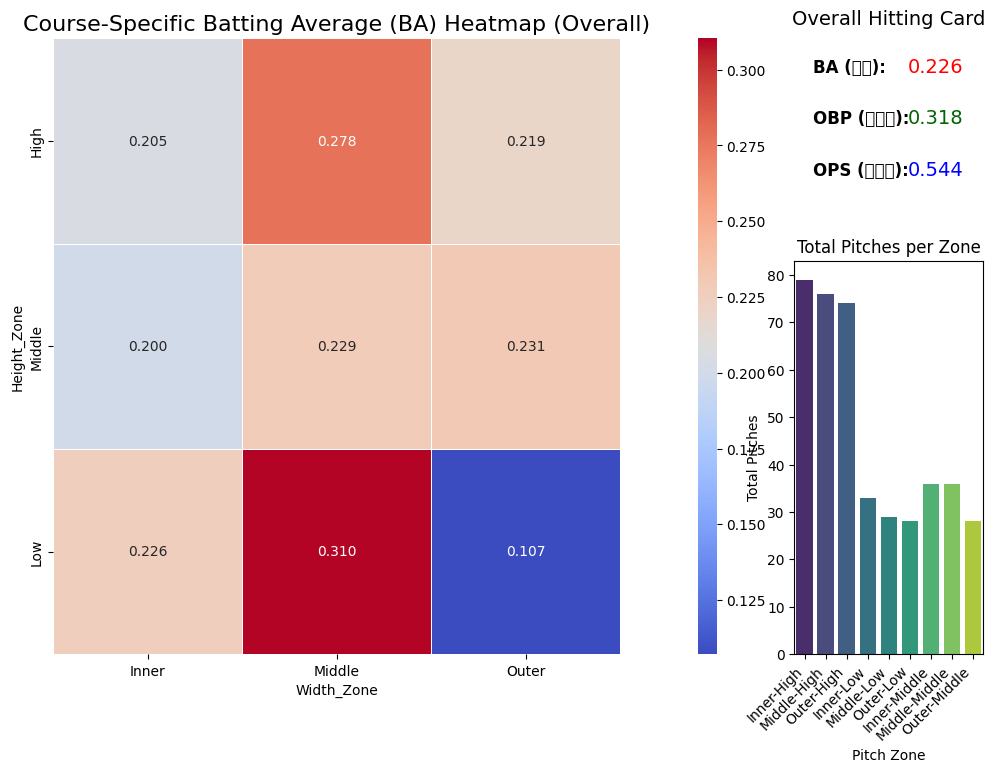

In [29]:
INPUT_CSV_PATH = 'play_info_dataset.csv' 

create_batting_heatmap(
    input_csv_path=INPUT_CSV_PATH,
    target_pitcher_id=None # Noneを設定するとフィルタリングを行いません
)

In [30]:
import os
print(os.getcwd())
OUTPUT_FILE = 'classified_pitch_data.csv'
# ... (保存コード) ...
# df_result.to_csv(OUTPUT_FILE, index=False)

/Users/misa.uramoto/Lecture/DS-programming2/lecture_sp/pit_dataset


### 投手の投げ方別成功率

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --- 日本語フォント設定 ---
import matplotlib.pyplot as plt
import platform

# Macの場合のフォント設定
if platform.system() == "Darwin":
    plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro" # Mac標準のフォント

# フォントが設定されない場合やWindowsの場合は別のフォントを試す
# 例: Windowsの場合は "MS Gothic" や "Yu Gothic"
else:
    # フォントが設定されない場合は、以下をコメントアウトして試してください
    # plt.rcParams["font.family"] = "IPAexGothic"
    pass 

# グラフのマイナス記号設定（日本語フォント使用時の一般的な設定）
plt.rcParams["axes.unicode_minus"] = False

print("✅ 日本語フォント設定を試みました。")

✅ 日本語フォント設定を試みました。


In [32]:
def create_all_pitch_type_ranking(
    input_csv_path, 
    pitch_type_col='pitch_type', 
    pitcher_id_col='pitcher_id', 
    exclude_pitch_types=['Fastball', 'ストレート', '直球'], # ★除外したいストレート系の球種名を追加★
    min_at_bats=50
):
    """
    ストレート以外の全ての球種について、被打率が最も低い投手（成功率1位）を特定する。
    """
    
    # --- A. データ読み込み ---
    REQUIRED_COLS = ['is_h', 'is_ab', pitch_type_col, pitcher_id_col]
    
    try:
        # CP932エンコーディングで読み込みを試行
        df = pd.read_csv(input_csv_path, encoding='cp932')
        if not all(col in df.columns for col in REQUIRED_COLS):
            raise Exception("Missing required columns.")
            
    except Exception as e:
        print(f"🛑 エラーが発生しました: {e}。処理を終了します。CSVファイルのパス、エンコーディング、列名を確認してください。")
        return None

    # --- B. 対象となる球種リストの特定 ---
    
    # データをコピーし、必要な列が数値であることを確認
    df['is_h'] = pd.to_numeric(df['is_h'], errors='coerce')
    df['is_ab'] = pd.to_numeric(df['is_ab'], errors='coerce')
    df.dropna(subset=['is_h', 'is_ab'], inplace=True)
    
    # ストレート以外の球種を特定
    all_pitch_types = df[pitch_type_col].dropna().unique()
    target_pitch_types = [p for p in all_pitch_types if p not in exclude_pitch_types]
    
    if not target_pitch_types:
        print("⚠️ 警告: 除外リスト以外の分析対象となる球種が見つかりませんでした。")
        return None

    # --- C. 各球種でベストな投手を探索 ---
    
    results = []
    
    for pitch_type in target_pitch_types:
        # 特定の球種にフィルタリング
        filtered_df = df[df[pitch_type_col] == pitch_type].copy()
        
        # 投手別成績の集計
        pitcher_summary = filtered_df.groupby(pitcher_id_col).agg(
            total_hits=('is_h', 'sum'),
            total_at_bats=('is_ab', 'sum')
        ).reset_index()

        # 被打率(BA)の計算と閾値フィルタリング
        pitcher_summary['BA'] = np.where(pitcher_summary['total_at_bats'] > 0, 
                                         pitcher_summary['total_hits'] / pitcher_summary['total_at_bats'], np.nan)
        
        ranking = pitcher_summary[pitcher_summary['total_at_bats'] >= min_at_bats].copy()
        
        if not ranking.empty:
            # 被打率が低い順（成功率が高い順）にソートし、1位を取得
            ranking = ranking.sort_values(by='BA', ascending=True)
            best_pitcher = ranking.iloc[0]
            
            results.append({
                '球種': pitch_type,
                '1位投手ID': best_pitcher[pitcher_id_col],
                '被打率 (BA)': best_pitcher['BA'],
                '打数 (AB)': int(best_pitcher['total_at_bats'])
            })

    # --- D. ランキング結果の表示 ---
    
    final_ranking_df = pd.DataFrame(results)
    
    if final_ranking_df.empty:
        print(f"⚠️ 警告: {min_at_bats}打数以上のデータを持つ、ストレート以外の球種が見つかりませんでした。")
        return None

    print(f"\n--- ストレート以外の球種別 成功率ランキング (最低{min_at_bats}打数) ---")
    print(final_ranking_df.to_markdown(index=False, floatfmt=".3f"))
    
    return final_ranking_df

In [34]:
# --- 実行セクション ---

INPUT_CSV_PATH = 'play_info_dataset.csv'
PITCH_TYPE_COLUMN = 'pitch_type_name'  # 球種が格納されている列名
PITCHER_ID_COLUMN = 'pitcher_id' # 投手IDが格納されている列名

# データに含まれるストレートを示す値に合わせてリストを修正してください。
EXCLUDE_STRAIGHTS = ['Fastball', 'Straight', 'フォーシーム', '直球'] 
MIN_AB_THRESHOLD = 50 

ranking_all_pitches = create_all_pitch_type_ranking(
    input_csv_path=INPUT_CSV_PATH,
    pitch_type_col=PITCH_TYPE_COLUMN,
    pitcher_id_col=PITCHER_ID_COLUMN,
    exclude_pitch_types=EXCLUDE_STRAIGHTS,
    min_at_bats=MIN_AB_THRESHOLD
)

🛑 エラーが発生しました: [Errno 2] No such file or directory: 'play_info_dataset.csv'。処理を終了します。CSVファイルのパス、エンコーディング、列名を確認してください。
